### Eigenvectors for the unit sphere Laplacian, aka spherical harmonics

In this code we solve the solve for the eigenvalue-eigenvectos for the Laplacian on the sphere.

In [1]:
from dolfin import *

if not has_linear_algebra_backend("PETSc"):
    print("DOLFIN has not been configured with PETSc. Exiting.")
    exit()
if not has_slepc():
    print("DOLFIN has not been configured with SLEPc. Exiting.")
    exit()

In [2]:
from mshr import *
from math import pi, log
#import math 


import numpy as np
import matplotlib.pyplot as mpl

We generate the grids using another program (to save time and memory) o get some from other people (the nice icosaedral ones)
Only the coarsest is working. Do not know why. The grids seems to be OK.

In [22]:
#Ball = Sphere(Point(0.0, 0.0, 0.0), 1)
#Ball_mesh = generate_mesh(Ball,128)
#mesh = BoundaryMesh(Ball_mesh, "exterior")

mesh = Mesh("meshes/sphere_ico6.xml.gz")
#mesh = Mesh("meshes/sphere_128_mesh.xml.gz")
#mesh = Mesh("meshes/sphere_64_mesh.xml.gz")
#mesh = UnitSphereMesh(32) #does not work
#plot(mesh)

In [23]:
V = FunctionSpace(mesh, "CG", 2)
#W = VectorFunctionSpace(mesh, "CG",3)
#V = FunctionSpace(mesh,"Lagrange", mesh, 1)
#W = MixedElement([V, V])
#Vcomplex = FunctionSpace(mesh, W)

# to test the grids (plot them) uncomment the lines below and 
# go to the save file cell at the end.
#u_n = Function(V)
#u_n = project(Constant(1),V)

In [24]:
p = Constant(1)
q = Constant(0)
r = Constant(1)
d = Constant(0)
#n = FacetNormal(mesh)
# Normal direction
#up_expr = Expression(("x[0]/(x[0]*x[0]+x[1]*x[1]+x[2]*x[2])",\
#                      "x[1]/(x[0]*x[0]+x[1]*x[1]+x[2]*x[2])",\
#                      "x[2]/(x[0]*x[0]+x[1]*x[1]+x[2]*x[2])"),degree=2)
#up = interpolate(up_expr, W)
#up = project(up_expr, W)

u = TrialFunction(V)
v = TestFunction(V)

a = p*(dot(grad(u), grad(v)))*dx
#a = p*(dot(grad(u), grad(v)) - d*dot(up,grad(u))*dot(up,grad(v)))*dx
b = q*dot(u,v)*dx
c = r*dot(u,v)*dx

In [25]:
# Assemble into PETSc matrices
#dummy = v[0]*dx
dummy = v*dx
A = PETScMatrix()
B = PETScMatrix()
l = PETScVector()

#A = assemble(a+b)
assemble_system(a+b, dummy, A_tensor=A, b_tensor=l)
#assemble_system(a, dummy, bcs, A_tensor=A)
#[bc.zero(A) for bc in bcs]
#B = assemble(c)
assemble_system(c, dummy, A_tensor=B, b_tensor=l)
#assemble_system(c, dummy, bcs, A_tensor=B)
#[bc.zero(B) for bc in bcs]

#E = SLEPc.PEP().create()
#E.setOperators([A.mat(), B.mat(), A.mat()]) 

(<dolfin.cpp.la.PETScMatrix at 0x13b20ab30>,
 <dolfin.cpp.la.PETScVector at 0x13c2919a0>)

In [26]:
#solve now around
point = 20.
eigensolver = SLEPcEigenSolver(A, B)
eigensolver.parameters["solver"] = "krylov-schur"
#eigensolver.parameters["solver"] = "arnoldi"
#eigensolver.parameters["solver"] = "subspace"
#eigensolver.parameters["solver"] = "lanczos"
eigensolver.parameters["problem_type"] = "gen_hermitian"
#eigensolver.parameters["problem_type"] = "hermitian"
#eigensolver.parameters["spectrum"] = "target magnitude"
eigensolver.parameters['spectrum'] = 'target real'
eigensolver.parameters["spectral_transform"] = "shift-and-invert"
eigensolver.parameters["spectral_shift"] = point
eigensolver.parameters["tolerance"] = 1.e-1 # 1.e-14
eigensolver.parameters["maximum_iterations"] = 10000


PETScOptions.set("eps_view")

#eigensolver.parameters["spectrum"] = 'smallest real'
neigs = 40
eigensolver.solve(neigs)
print(eigensolver.get_number_converged())

62


In [27]:
computed_eigenvalues = []
positive_computed_eigenvalues = []
negative_computed_eigenvalues = []
different_eigenvalues = []

for i in range(min(neigs, eigensolver.get_number_converged())):
    r, _ = eigensolver.get_eigenvalue(i) # ignore the imaginary part
    computed_eigenvalues.append(r)
    
num_eig = np.sort(np.array(computed_eigenvalues))
length = len(num_eig)
different_eigenvalues.append(num_eig[0])

for i in range(1,length):
    if (abs(num_eig[i] - np.array(different_eigenvalues)[-1])) > 0.1:
        different_eigenvalues.append(num_eig[i])
    
diff_length = len(different_eigenvalues)

np.set_printoptions(formatter={'float': '{:5.5f}'.format})

#print("Numerical eigenvalues:  {}".format(np.array(different_eigenvalues)))
#print("Sorted: {}".format(np.array(num_eig)))
print("Unsorted: {}".format(np.array(computed_eigenvalues)))

Unsorted: [20.00587 20.00587 20.00587 20.00588 20.00602 20.00603 20.00603 20.00603
 20.00603 12.00364 12.00364 12.00364 12.00352 12.00352 12.00352 12.00352
 30.00888 30.00888 30.00888 30.00890 30.00891 30.00891 30.00891 30.00914
 30.00914 30.00915 6.00179 6.00178 6.00178 6.00178 6.00178 2.00059 2.00059
 2.00059 -0.00000 42.01247 42.01247 42.01256 42.01257 42.01271]


We can now compare with the true eigenvalues

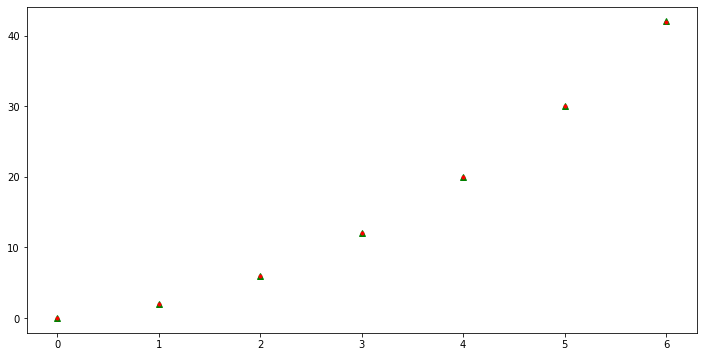

In [28]:
true_eig = np.sort(np.array([float((m+1)*m)\
    for m in range(diff_length)]))#[1:length+1]
#print("Exact eigenvalues:  {}".format(true_eig))
mpl.figure(figsize=(12,6)) 
x = np.arange(diff_length)
mpl.plot(x,different_eigenvalues[:diff_length],'g^',x,true_eig[:diff_length],'r.')

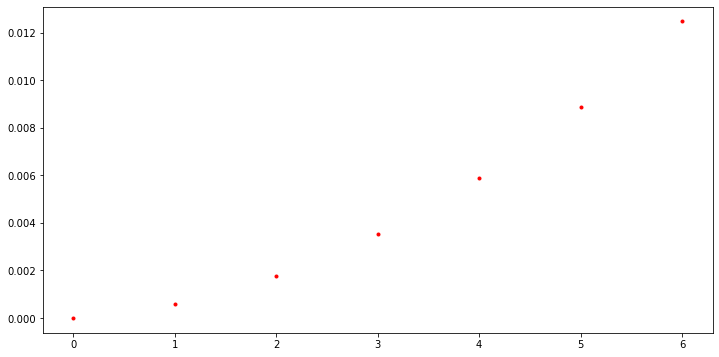

In [29]:
mpl.figure(figsize=(12,6)) 
x = np.arange(diff_length)
mpl.plot(x,different_eigenvalues[:diff_length] - true_eig[:diff_length],'r.')

And we can plot some of them (remember they are complex, so we plot some part only)

In [30]:
r, c, rx, cx = eigensolver.get_eigenpair(0) 
# for tests_1 and 2 use n=10 for test_3 use 3
print('The eigenvalue is: %2.5f'%r)

# save for plotting

u = Function(V)
u.vector()[:] = rx


# Re-scale solution to have L2 norm unity.
u_n = Function(V)

square = inner(u,u)*dx
L2_inv = 1./sqrt(assemble(square))

u_n = project(L2_inv*u,V)
    
square = inner(u_n,u_n)*dx
print("This should be unit = %2.2f"%assemble(square))

The eigenvalue is: 20.00587
Calling FFC just-in-time (JIT) compiler, this may take some time.
This should be unit = 1.00


In [31]:
# Save solution to file in VTK format

vtkfile_u = File('Eigenvectors/u128.pvd')
vtkfile_u << u_n